In [1]:
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import skimage
import tensorflow_io as tfio
import pickle
import cv2

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, InputLayer
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from keras import utils, callbacks
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from keras.losses import CategoricalCrossentropy
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten

from sklearn import metrics
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from skimage import transform

# Uploading All Images 

In [2]:
batch_size = 64
imageSize = 64
target_dims = (imageSize, imageSize, 3)
num_classes = 87000

train_len = 87000
train_dir = 'Data/asl_alphabet_train/'

def get_data(folder):
    X = np.empty((train_len, imageSize, imageSize, 3), dtype=np.float32)
    y = np.empty((train_len,), dtype=np.int)
    cnt = 0
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['A']:
                label = 0
            elif folderName in ['B']:
                label = 1
            elif folderName in ['C']:
                label = 2
            elif folderName in ['D']:
                label = 3
            elif folderName in ['E']:
                label = 4
            elif folderName in ['F']:
                label = 5
            elif folderName in ['G']:
                label = 6
            elif folderName in ['H']:
                label = 7
            elif folderName in ['I']:
                label = 8
            elif folderName in ['J']:
                label = 9
            elif folderName in ['K']:
                label = 10
            elif folderName in ['L']:
                label = 11
            elif folderName in ['M']:
                label = 12
            elif folderName in ['N']:
                label = 13
            elif folderName in ['O']:
                label = 14
            elif folderName in ['P']:
                label = 15
            elif folderName in ['Q']:
                label = 16
            elif folderName in ['R']:
                label = 17
            elif folderName in ['S']:
                label = 18
            elif folderName in ['T']:
                label = 19
            elif folderName in ['U']:
                label = 20
            elif folderName in ['V']:
                label = 21
            elif folderName in ['W']:
                label = 22
            elif folderName in ['X']:
                label = 23
            elif folderName in ['Y']:
                label = 24
            elif folderName in ['Z']:
                label = 25
            elif folderName in ['del']:
                label = 26
            elif folderName in ['nothing']:
                label = 27
            elif folderName in ['space']:
                label = 28           
            else:
                label = 29
            for image_filename in os.listdir(folder + folderName):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    img_arr = np.asarray(img_file).reshape((-1, imageSize, imageSize, 3))
                    
                    X[cnt] = img_arr
                    y[cnt] = label
                    cnt += 1
    return X,y
X, y = get_data(train_dir)
print("Images successfully imported...")

<ipython-input-2-9ff973cfca85>:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.empty((train_len,), dtype=np.int)


Images successfully imported...


# having a look about what each class looks like

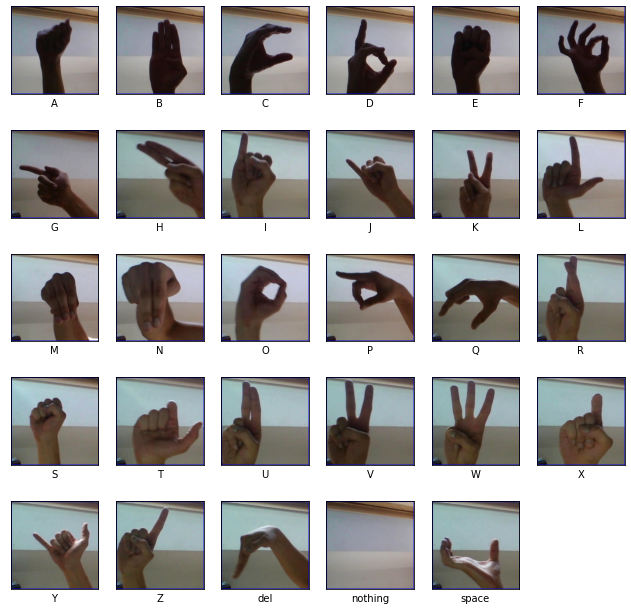

In [3]:
train_dir = 'Data/asl_alphabet_train'
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V',
           'W', 'X', 'Y', 'Z',  'del','nothing', 'space']
plt.figure(figsize=(11, 11))
for i in range (0,29):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    path = train_dir + "/{0}/{0}1.jpg".format(classes[i])
    img = plt.imread(path)
    plt.imshow(img)
    plt.xlabel(classes[i])
plt.savefig('HH.JPG',transparent=True,bbox_inches='tight')

# splitting to train and validation 

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .05, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = .05451, random_state = 42)

## A function that returns the accuracy of a model 

In [5]:
def get_accuracy(X):
    predict_tr = X.predict(X_train) 
    classes_tr = np.argmax(predict_tr, axis=1)
    predict_val = X.predict(X_val) 
    classes_val = np.argmax(predict_val, axis=1)

    print(f'Training: {accuracy_score(y_train, classes_tr)}')
    print(f'Val: {accuracy_score(y_val, classes_val)}')

### a function that returns mean absolut error and squared absolut error 

In [6]:
def benchmark(model):
    classes_tr = model.predict(X_val)
    y_pred = np.argmax(classes_tr, axis=1)
    print(f"mae: {metrics.mean_absolute_error(y_val, y_pred):,.2f}")
    print(f"mse: {metrics.mean_squared_error(y_val, y_pred):,.2f}")

In [116]:
y_cat_train = to_categorical(y_train,29)
y_cat_val = to_categorical(y_val,29)
y_cat = to_categorical(y,29)
y_cat_test = to_categorical(y_test,29)

In [21]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)
L2 = 50
DROP = 0.05

# Baselines

### Regression model

In [9]:
X_train_n = X_train.reshape(78144,64*64*3) 
X_val_n = X_val.reshape(4350,64*64*3) 

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
lr_Baseline = LogisticRegression()
lr_Baseline.fit(X_train_n,y_train)
print(accuracy_score(y_train,lr_Baseline.predict(X_train_n)))
print(accuracy_score(y_val,lr_Baseline.predict(X_val_n)))

C:\Users\mryas\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.542204135954136
0.5377011494252874


## simple NN model 

In [12]:
Simple_NN_model = keras.Sequential([
    keras.layers.InputLayer((64,64,3)),
    Flatten(),
    keras.layers.Dense(units=5, activation="relu"),
    keras.layers.Dense(units=29),
])
Simple_NN_model.compile("sgd", loss="mean_absolute_error", metrics=["mean_squared_error"])

In [13]:
Simple_NN_model.fit(X_train, y_cat_train, epochs=5)

Epoch 1/5
2442/2442 [==============================] - 4s 1ms/step - loss: 0.0348 - mean_squared_error: 0.0346
Epoch 2/5
2442/2442 [==============================] - 3s 1ms/step - loss: 0.0346 - mean_squared_error: 0.0345
Epoch 3/5
2442/2442 [==============================] - 3s 1ms/step - loss: 0.0346 - mean_squared_error: 0.0345
Epoch 4/5
2442/2442 [==============================] - 3s 1ms/step - loss: 0.0346 - mean_squared_error: 0.0345
Epoch 5/5
2442/2442 [==============================] - 3s 1ms/step - loss: 0.0346 - mean_squared_error: 0.0345


In [14]:
get_accuracy(Simple_NN_model)

Training: 0.03470515970515971
Val: 0.03333333333333333


In [15]:
benchmark(Simple_NN_model)

mae: 13.17
mse: 241.34


## more complex NN

In [16]:
NN_Baseline = Sequential(
                        [InputLayer(input_shape=(64,64,3)),
                         Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'),
                         MaxPooling2D(),
                         Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
                         MaxPooling2D(),
                         Flatten(),
                         Dense(20, activation='relu'),
                         Dense(29, activation='softmax')]
                       )

NN_Baseline.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

In [17]:
NN_Baseline.fit(X_train, y_cat_train, epochs=5, verbose=1, validation_split=0.25)


Epoch 1/5
1832/1832 [==============================] - 44s 24ms/step - loss: 1.8254 - accuracy: 0.4328 - val_loss: 0.9195 - val_accuracy: 0.6953
Epoch 2/5
1832/1832 [==============================] - 45s 24ms/step - loss: 0.6494 - accuracy: 0.7807 - val_loss: 0.5370 - val_accuracy: 0.8247
Epoch 3/5
1832/1832 [==============================] - 45s 24ms/step - loss: 0.3453 - accuracy: 0.8847 - val_loss: 0.3263 - val_accuracy: 0.8856
Epoch 4/5
1832/1832 [==============================] - 45s 25ms/step - loss: 0.2079 - accuracy: 0.9303 - val_loss: 0.1657 - val_accuracy: 0.9487
Epoch 5/5
1832/1832 [==============================] - 48s 26ms/step - loss: 0.1425 - accuracy: 0.9534 - val_loss: 0.1556 - val_accuracy: 0.9491


In [18]:
get_accuracy(NN_Baseline)

Training: 0.9596514127764127
Val: 0.9510344827586207


In [19]:
benchmark(NN_Baseline)

mae: 0.22
mse: 2.09


# even more complex CNN with droput and early stopping

In [22]:
NN_Baseline1 = Sequential(
                        [InputLayer(input_shape=(64,64,3)),
                         Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'),
                         MaxPooling2D(),
                         Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
                         MaxPooling2D(),
                         Flatten(),
                         Dense(100, activation='relu'),
                         keras.layers.Dropout(DROP),
                         Dense(70, activation='relu'),
                         keras.layers.Dropout(DROP),
                         Dense(40, activation='relu'),
                         keras.layers.Dropout(DROP),                         
                         Dense(29, activation='softmax')]
                       )

NN_Baseline1.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

In [23]:
NN_Baseline1.fit(X_train, y_cat_train, epochs=10, verbose=1,callbacks=[early_stop], validation_split=0.25)


Epoch 1/10
1832/1832 [==============================] - 47s 26ms/step - loss: 1.5388 - accuracy: 0.4984 - val_loss: 0.5282 - val_accuracy: 0.8158
Epoch 2/10
1832/1832 [==============================] - 47s 26ms/step - loss: 0.4863 - accuracy: 0.8288 - val_loss: 0.2428 - val_accuracy: 0.9175
Epoch 3/10
1832/1832 [==============================] - 47s 26ms/step - loss: 0.2845 - accuracy: 0.9019 - val_loss: 0.1337 - val_accuracy: 0.9509
Epoch 4/10
1832/1832 [==============================] - 47s 26ms/step - loss: 0.2012 - accuracy: 0.9320 - val_loss: 0.0883 - val_accuracy: 0.9729
Epoch 5/10
1832/1832 [==============================] - 47s 26ms/step - loss: 0.1692 - accuracy: 0.9437 - val_loss: 0.0777 - val_accuracy: 0.9746
Epoch 6/10
1832/1832 [==============================] - 47s 26ms/step - loss: 0.1361 - accuracy: 0.9552 - val_loss: 0.0600 - val_accuracy: 0.9832
Epoch 7/10
1832/1832 [==============================] - 47s 26ms/step - loss: 0.1122 - accuracy: 0.9634 - val_loss: 0.0567 -

In [24]:
get_accuracy(NN_Baseline1)

Training: 0.9961481367731367
Val: 0.992183908045977


In [25]:
base = Sequential(
                        [InputLayer(input_shape=(64,64,3)),
                         Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'),
                         MaxPooling2D(),
                         Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
                         MaxPooling2D(),
                         Flatten(),
                         keras.layers.Dense(units=100, activation="relu",
                                            kernel_regularizer=keras.regularizers.l2(L2)),
                         keras.layers.Dropout(DROP),
                         keras.layers.Dense(units=80, activation="relu",
                                            kernel_regularizer=keras.regularizers.l2(L2)),
                         keras.layers.Dropout(DROP),
                         keras.layers.Dense(units=60, activation="relu",
                                            kernel_regularizer=keras.regularizers.l2(L2)),
                         keras.layers.Dense(29, activation='softmax')]
                       )

base.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)
base.fit(X_train, y_cat_train, epochs=5, verbose=1, validation_split=0.25)
get_accuracy(test)

Epoch 1/5
1832/1832 [==============================] - 50s 27ms/step - loss: 286.6070 - accuracy: 0.0330 - val_loss: 3.3693 - val_accuracy: 0.0346
Epoch 2/5
1832/1832 [==============================] - 50s 27ms/step - loss: 3.3696 - accuracy: 0.0327 - val_loss: 3.3706 - val_accuracy: 0.0335
Epoch 3/5
1832/1832 [==============================] - 50s 27ms/step - loss: 3.3701 - accuracy: 0.0341 - val_loss: 3.3701 - val_accuracy: 0.0346
Epoch 4/5
1832/1832 [==============================] - 50s 27ms/step - loss: 3.3703 - accuracy: 0.0330 - val_loss: 3.3702 - val_accuracy: 0.0318
Epoch 5/5
1832/1832 [==============================] - 50s 27ms/step - loss: 3.3702 - accuracy: 0.0329 - val_loss: 3.3702 - val_accuracy: 0.0339
Training: 0.03470515970515971
Val: 0.03425287356321839


# Transfer Learning

### pretrained model VGG16

In [26]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import ZeroPadding2D, Dropout 
base = VGG16(weights='imagenet', include_top=False, input_shape=(64,64,3))


for layer in base.layers:
    layer.trainable = False  

NN_transfer = Sequential(
                        [InputLayer(input_shape=(64,64,3)),
                         base,
                         Flatten(),
                         Dense(1000, activation='relu'),
                         Dense(1000, activation='relu'),
                         Dense(29, activation='softmax')]
                       )

NN_transfer.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

In [27]:
NN_transfer.fit(X_train, y_cat_train, epochs=4, verbose=1, validation_split=0.25)

Epoch 1/4
1832/1832 [==============================] - 331s 181ms/step - loss: 0.3838 - accuracy: 0.8780 - val_loss: 0.1289 - val_accuracy: 0.9535
Epoch 2/4
1832/1832 [==============================] - 329s 180ms/step - loss: 0.1061 - accuracy: 0.9641 - val_loss: 0.0428 - val_accuracy: 0.9861
Epoch 3/4
1832/1832 [==============================] - 334s 182ms/step - loss: 0.0710 - accuracy: 0.9769 - val_loss: 0.1262 - val_accuracy: 0.9610
Epoch 4/4
1832/1832 [==============================] - 342s 187ms/step - loss: 0.0595 - accuracy: 0.9807 - val_loss: 0.0402 - val_accuracy: 0.9873


In [28]:
get_accuracy(NN_transfer)

Training: 0.988828316953317
Val: 0.9903448275862069


In [29]:
benchmark(NN_transfer)

mae: 0.07
mse: 0.80


### pretrained model NASNetLarge

In [143]:
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.layers import ZeroPadding2D, Dropout 
base = VGG16(weights='imagenet', include_top=False, input_shape=(64,64,3))


for layer in base.layers:
    layer.trainable = False  

NN_transfer_NASN = Sequential(
                        [InputLayer(input_shape=(64,64,3)),
                         base,
                         Flatten(),
                         Dense(1000, activation='relu'),
                         Dense(1000, activation='relu'),
                         Dense(29, activation='softmax')]
                       )

NN_transfer_NASN.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

In [144]:
NN_transfer_NASN.fit(X_train, y_cat_train, epochs=4, verbose=1, validation_split=0.25)

Epoch 1/4
1832/1832 [==============================] - 331s 181ms/step - loss: 0.3793 - accuracy: 0.8802 - val_loss: 0.0965 - val_accuracy: 0.9658
Epoch 2/4
1832/1832 [==============================] - 335s 183ms/step - loss: 0.1044 - accuracy: 0.9640 - val_loss: 0.1214 - val_accuracy: 0.9632
Epoch 3/4
1832/1832 [==============================] - 338s 184ms/step - loss: 0.0757 - accuracy: 0.9751 - val_loss: 0.0514 - val_accuracy: 0.9807
Epoch 4/4
1832/1832 [==============================] - 340s 186ms/step - loss: 0.0592 - accuracy: 0.9814 - val_loss: 0.0319 - val_accuracy: 0.9882


In [145]:
get_accuracy(NN_transfer_NASN)

Training: 0.9903383497133497
Val: 0.9914942528735632


# Best model

best model with early stopping 

In [30]:
model = Sequential()

model.add(Conv2D(32, (5, 5), input_shape=(64, 64, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dense(29, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 60, 60, 32)        2432      
                                                                 
 activation (Activation)     (None, 60, 60, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                  

In [31]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
history = model.fit(X_train, y_cat_train,
          epochs=50,
          batch_size=16,
          verbose=2,
          validation_data=(X_val, y_cat_val),
         callbacks=[early_stop])

Epoch 1/50
4884/4884 - 110s - loss: 0.6975 - accuracy: 0.7890 - val_loss: 0.1413 - val_accuracy: 0.9531 - 110s/epoch - 23ms/step
Epoch 2/50
4884/4884 - 110s - loss: 0.1010 - accuracy: 0.9674 - val_loss: 0.0568 - val_accuracy: 0.9798 - 110s/epoch - 23ms/step
Epoch 3/50
4884/4884 - 110s - loss: 0.0595 - accuracy: 0.9816 - val_loss: 0.0411 - val_accuracy: 0.9853 - 110s/epoch - 23ms/step
Epoch 4/50
4884/4884 - 120s - loss: 0.0467 - accuracy: 0.9860 - val_loss: 0.0351 - val_accuracy: 0.9894 - 120s/epoch - 25ms/step
Epoch 5/50
4884/4884 - 122s - loss: 0.0397 - accuracy: 0.9879 - val_loss: 0.0248 - val_accuracy: 0.9924 - 122s/epoch - 25ms/step
Epoch 6/50
4884/4884 - 121s - loss: 0.0334 - accuracy: 0.9902 - val_loss: 0.0528 - val_accuracy: 0.9844 - 121s/epoch - 25ms/step
Epoch 7/50
4884/4884 - 121s - loss: 0.0328 - accuracy: 0.9913 - val_loss: 0.0209 - val_accuracy: 0.9947 - 121s/epoch - 25ms/step
Epoch 8/50
4884/4884 - 120s - loss: 0.0305 - accuracy: 0.9917 - val_loss: 0.0233 - val_accuracy: 

In [33]:
get_accuracy(model)
benchmark(model)

Training: 0.9973510442260443
Val: 0.9949425287356322
mae: 0.03
mse: 0.24


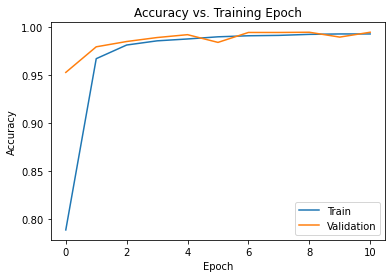

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Accuracy vs. Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'])

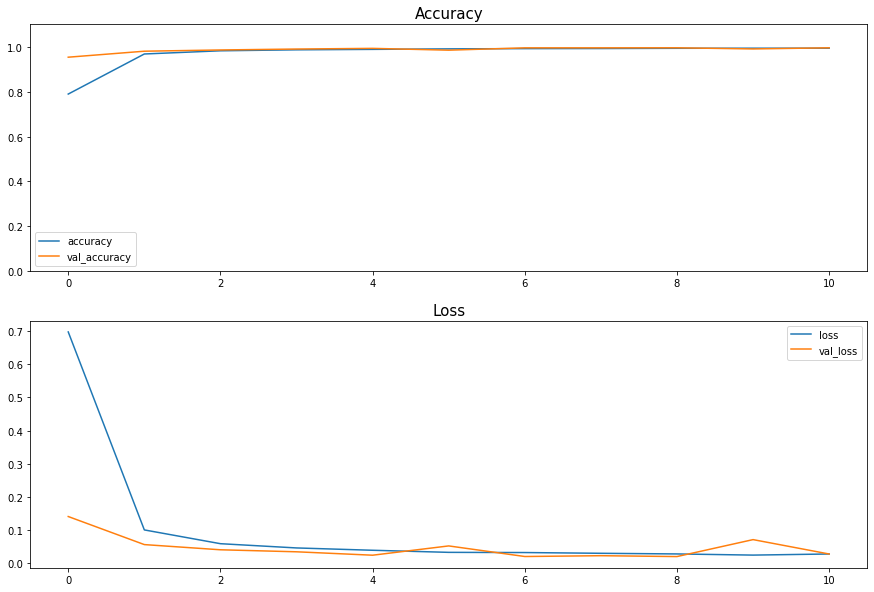

In [35]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax = axes.flat

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(ax=ax[0])
ax[0].set_title("Accuracy", fontsize = 15)
ax[0].set_ylim(0,1.1)

pd.DataFrame(history.history)[['loss','val_loss']].plot(ax=ax[1])
ax[1].set_title("Loss", fontsize = 15)
plt.show()

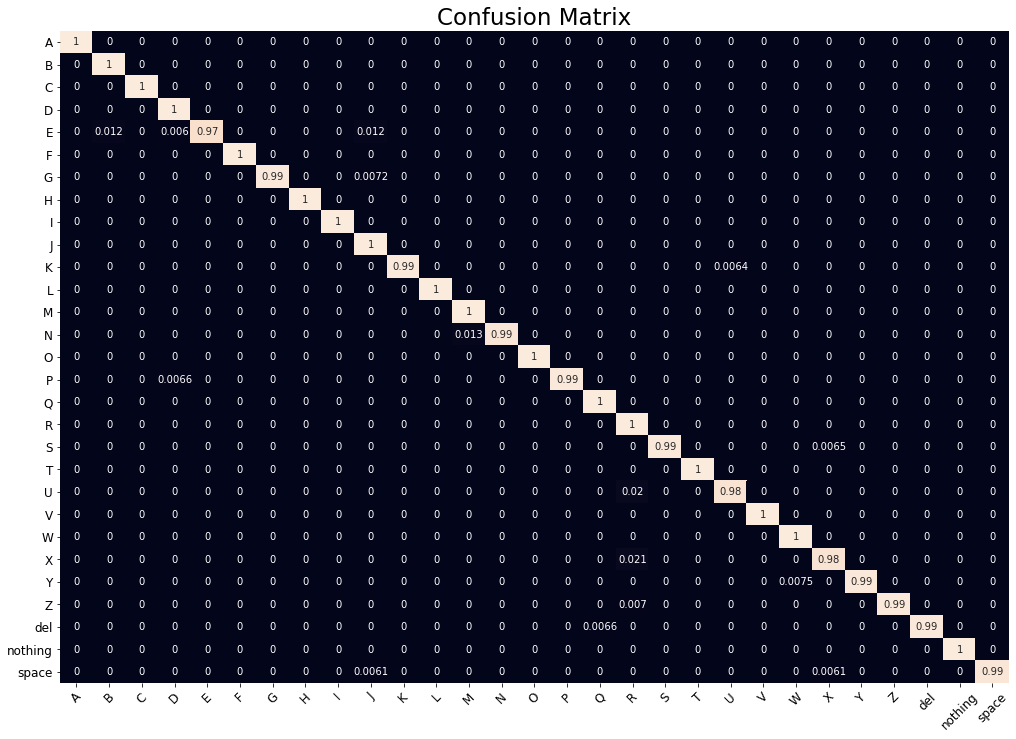

In [146]:
pred = model.predict(X_val)
pred = np.argmax(pred,axis=1)



acc = accuracy_score(y_val,pred)

# Display a confusion matrix
cf_matrix = confusion_matrix(y_val, pred, normalize='true')
plt.figure(figsize = (17,12))
sns.heatmap(cf_matrix, annot=True, xticklabels = classes, yticklabels = classes,cbar=False)
plt.title('Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=12,rotation=45)
plt.yticks(fontsize=12)
plt.show()

# Final model on test data

In [ ]:
train_len = 29
X_test, y_test = get_data('Data/asl_alphabet_test/')

In [132]:
final = Sequential()

final.add(Conv2D(32, (5, 5), input_shape=(64, 64, 3)))
final.add(Activation('relu'))
final.add(MaxPooling2D((2, 2)))

final.add(Conv2D(64, (3, 3)))
final.add(Activation('relu'))
final.add(MaxPooling2D((2, 2)))

final.add(Conv2D(64, (3, 3)))
final.add(Activation('relu'))
final.add(MaxPooling2D((2, 2)))

final.add(Flatten())

final.add(Dense(128, activation='relu'))

final.add(Dense(29, activation='softmax'))


final.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [133]:
history_final = final.fit(X, y_cat,
          epochs=10,
          batch_size=16,
          verbose=2,
         callbacks=[early_stop]) 

Epoch 1/10
5438/5438 - 123s - loss: 0.5335 - accuracy: 0.8363 - 123s/epoch - 23ms/step
Epoch 2/10
5438/5438 - 123s - loss: 0.0755 - accuracy: 0.9764 - 123s/epoch - 23ms/step
Epoch 3/10
5438/5438 - 123s - loss: 0.0442 - accuracy: 0.9872 - 123s/epoch - 23ms/step
Epoch 4/10
5438/5438 - 123s - loss: 0.0385 - accuracy: 0.9889 - 123s/epoch - 23ms/step
Epoch 5/10
5438/5438 - 132s - loss: 0.0325 - accuracy: 0.9916 - 132s/epoch - 24ms/step
Epoch 6/10
5438/5438 - 131s - loss: 0.0334 - accuracy: 0.9916 - 131s/epoch - 24ms/step
Epoch 7/10
5438/5438 - 128s - loss: 0.0292 - accuracy: 0.9928 - 128s/epoch - 24ms/step
Epoch 8/10
5438/5438 - 131s - loss: 0.0232 - accuracy: 0.9941 - 131s/epoch - 24ms/step
Epoch 9/10
5438/5438 - 126s - loss: 0.0223 - accuracy: 0.9945 - 126s/epoch - 23ms/step
Epoch 10/10
5438/5438 - 125s - loss: 0.0265 - accuracy: 0.9943 - 125s/epoch - 23ms/step


In [134]:
predict_tr = final.predict(X) 
classes_tr = np.argmax(predict_tr, axis=1)
predict_val = final.predict(X_test) 
classes_val = np.argmax(predict_val, axis=1)

print(f'Training: {accuracy_score(y, classes_tr)}')
print(f'Val: {accuracy_score(y_test, classes_val)}')

Training: 0.998367816091954
Val: 1.0


# our final model prediction with unseen images 

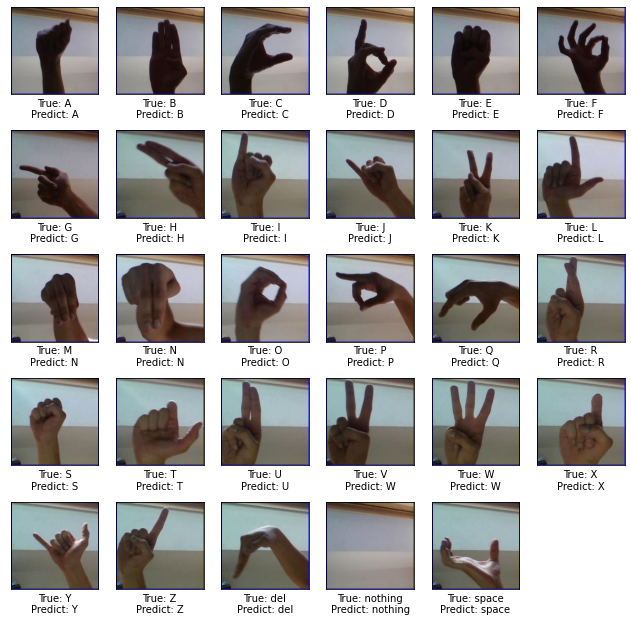

In [172]:
plt.figure(figsize=(11, 11))
for i in range (0,29):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    img = image.load_img('data/asl_alphabet_test/{0}/{0}_test.jpg'.format(classes[i]),target_size=(64,64))
    Z = image.img_to_array(img)
    Z = np.expand_dims(Z,axis=0)
    images = np.vstack([Z])
    val = final.predict([images])
    ind = max(val).argmax()
    path = train_dir + "/{0}/{0}1.jpg".format(classes[i])
    img = plt.imread(path)
    plt.imshow(img)
    plt.xlabel(f'True: {classes[i]}\n' + f'Predict: {classes[ind]}')
plt.savefig('pre.JPG',transparent=True,bbox_inches='tight')

## a predction of low accuracy model that we built before 

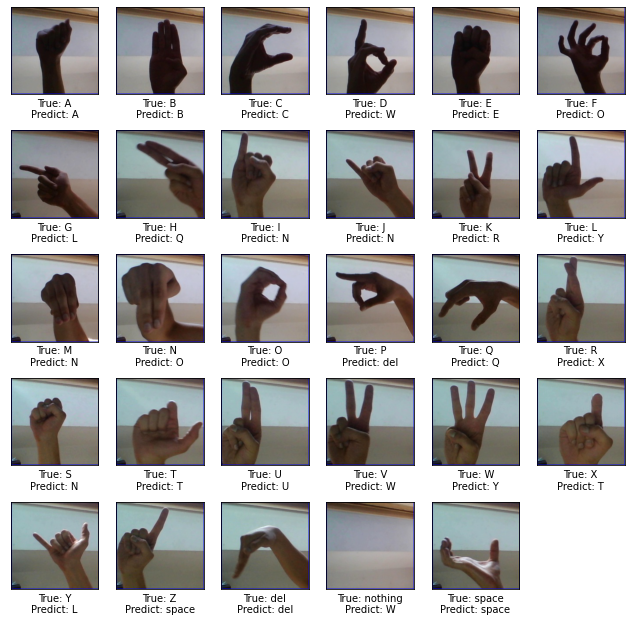

In [171]:
plt.figure(figsize=(11, 11))
for i in range (0,29):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    img = image.load_img('data/asl_alphabet_test/{0}/{0}_test.jpg'.format(classes[i]),target_size=(64,64))
    Z = image.img_to_array(img)
    Z = np.expand_dims(Z,axis=0)
    images = np.vstack([Z])
    val = Simple_NN_model.predict([images])
    ind = max(val).argmax()
    path = train_dir + "/{0}/{0}1.jpg".format(classes[i])
    img = plt.imread(path)
    plt.imshow(img)
    plt.xlabel(f'True: {classes[i]}\n' + f'Predict: {classes[ind]}')
plt.savefig('pre.JPG',transparent=True,bbox_inches='tight')

In [ ]:
val.argmax()

In [ ]:
np.where(k==max(k))[0][0]

In [156]:
final.save('model/')

INFO:tensorflow:Assets written to: yasir/assets
